In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline


In [ ]:
class NBinom:
    # Gamma-Poisson conjugate model -> Negative binomial predictive distribution
    hyper_par = np.array([1, 1])
    pred_par  = np.array([hyper_par[0], 1 / (1 + hyper_par[1])])
    hyper_size = 2
    pred_size  = 2
    
    DoF = 1
    
    def getPredictiveProbability(k, pred_par):
        return stats.nbinom.pmf(k, pred_par[0], 1 - pred_par[1])
    
    def getPredictiveSample(pred_par):
        return np.random.negative_binomial(pred_par[0], 1 - pred_par[1])
    
    def getPosteriorParameter(prior_par, x):
        return np.array([prior_par[0] + np.sum(x), prior_par[1] + (1 if type(x) == int else len(x))])
    
    def getAdaptedPosteriorParameter(prior_par, xt):
        xt = xt.squeeze()
        if xt != 0:
            alpha = prior_par[0] + xt
            beta  = alpha / xt
            return np.array([alpha, beta])
        else:
            getPosteriorParameter(prior_par, xt)
    
    def getPredictiveParameter(post_par):
        return np.array([post_par[0], 1 / (1 + post_par[1])])

In [19]:
model = NBinom

In [20]:
class BOCPD:
    def __init__(self, model, data):
        self.data = data
        self.r_size = 300
        self.T = len(self.data)
        self.init_run_length_at_zero = 1
        self.n_samples = 1000
        
        self.flag_lci = 0
        self.flag_rci = 1
        self.risk_level = 0.1
                    
        self.rlr = 1000
            
        self.resetParameters(model)
        
        self.pred_mean = np.zeros( (self.T, model.DoF) )
        if self.flag_lci: self.percentile_l = np.zeros( (self.T, model.DoF) )
        if self.flag_rci: self.percentile_r = np.zeros( (self.T, model.DoF) )
    
        self.changepoints = {}
    
    def apply(self):   
        self.getHazardFunction()    
        self.initProbabilities()    
        
        for t_ in range(self.T):
            self.getPredictiveStats(t_)          
            xt = self.data[t_,:]
            self.checkIfChangepoint(t_, xt)
            self.updateParameters(xt)      
            self.getRunLengthProbability(xt)
            
        
    def getRunLengthProbability(self, xt):
        pp = np.zeros(self.r_size)
        for r_ in range(self.r_size):
            pp[r_] = model.getPredictiveProbability(xt, self.pred_par[r_,:])
  
        jppp = self.jp * pp
        gp = jppp * ( 1 - self.H )
        cp = np.sum( jppp * self.H )
        self.jp  = np.hstack( (cp, gp[:-1]) )
        self.rlp = self.jp / np.sum( self.jp )
        

    def getPredictiveStats(self, t_):
        pps = np.zeros( (model.DoF, self.n_samples) )
        rld = stats.rv_discrete( values = ( np.arange(self.r_size), self.rlp ) )
        rls = rld.rvs( size = self.n_samples )
        for k in range(self.n_samples):
            pps[:,k] = model.getPredictiveSample(self.pred_par[ rls[k], : ])

        self.pred_mean[t_,:] = np.mean( pps, 1 )
        
        if self.flag_lci == 1 and self.flag_rci == 0:
            self.percentile_l[t_,:] = np.percentile(pps, self.risk_level, axis = 1)
        elif self.flag_lci == 0 and self.flag_rci == 1:
            self.percentile_r[t_,:] = np.percentile(pps, 100 - self.risk_level, axis = 1)
        elif self.flag_lci == 1 and self.flag_rci == 1:
            self.percentile_l[t_,:] = np.percentile(pps, 0.5 * self.risk_level, axis = 1)
            self.percentile_r[t_,:] = np.percentile(pps, 100 - 0.5 * self.risk_level, axis = 1)
            
    
    def updateParameters(self, xt):
        tmp = np.copy(self.hyper_par)
        for r_ in range(1, self.r_size):
            if self.is_t_changepoint == 0:
                self.hyper_par[r_,:] = model.getPosteriorParameter(tmp[r_ - 1,:], xt)
            else:
                self.hyper_par[r_,:] = model.getAdaptedPosteriorParameter(tmp[r_ - 1,:], xt)
                
            self.pred_par[r_,:]  = model.getPredictiveParameter(self.hyper_par[r_,:])

        
    def initProbabilities(self):
        if self.init_run_length_at_zero:
            self.jp = np.zeros(self.r_size)
            self.jp[0] = 1
        else:
            self.jp = self.H * (1 - self.H) ** np.arange(self.r_size)
            
        self.rlp = self.jp
        
    def getHazardFunction(self):
        self.H = 1 / self.rlr
        
    def resetParameters(self, model):
        self.hyper_par = model.hyper_par * np.ones( (self.r_size, model.hyper_size) )
        self.pred_par  = model.pred_par  * np.ones( (self.r_size, model.pred_size) )
        
    def checkIfChangepoint(self, t_, xt):        
        self.is_t_changepoint = 0
        
        if self.flag_lci: 
            for i_ in range(model.DoF):
                if xt[i_] < self.percentile_l[t_, i_]: 
                    print('Changepoint at time', t_, 'for drastic decrease')
                    self.changepoints.update({t_: np.linalg.norm(xt) / np.linalg.norm(self.percentile_l[t_,:])})
                    
                    self.init_run_length_at_zero = 1
                    self.initProbabilities()
                    
                    self.is_t_changepoint = 1
                    
                    break
        if self.flag_rci: 
            for i_ in range(model.DoF):
                if xt[i_] > self.percentile_r[t_, i_]: 
                    print('Changepoint at time', t_, 'for drastic increase')
                    self.changepoints.update({t_: np.linalg.norm(xt) / np.linalg.norm(self.percentile_r[t_,:])})
                    
                    self.init_run_length_at_zero = 1
                    self.initProbabilities()
                    
                    self.is_t_changepoint = 1
                    
                    break
                    
            


In [ ]:
data1 = np.random.poisson(lam = 1,  size = 100)
data2 = np.random.poisson(lam = 20, size = 150)
data3 = np.random.poisson(lam = 1, size = 150)
data4 = np.random.poisson(lam = 30, size = 100)
data = np.hstack( (data1, data2, data3, data4) )[:, np.newaxis]

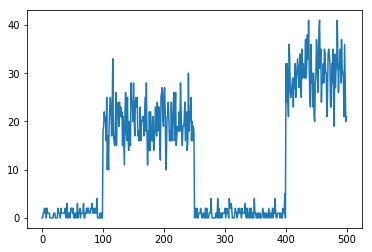

In [12]:
plt.plot(data)

In [21]:
bocpd = BOCPD(model, data)

In [22]:
bocpd.apply()

Changepoint at time 100 for drastic increase
Changepoint at time 400 for drastic increase


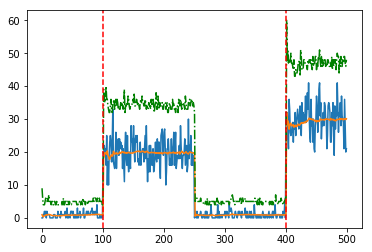

In [23]:
plt.plot(bocpd.data)
plt.plot(bocpd.pred_mean)
if bocpd.flag_rci: plt.plot(bocpd.percentile_r, 'g-.')
for cp in bocpd.changepoints:
    plt.axvline(x = cp, color = 'r', linestyle = '--')

In [24]:
bocpd.changepoints

{100: 3.0, 400: 5.333333333333333}